# West Nile Virus Mosquito Analysis

<img align="right" src='https://kaggle2.blob.core.windows.net/competitions/kaggle/4366/media/moggie2.png' width=5%>

https://www.kaggle.com/c/predict-west-nile-virus


By: GU ZHAN (Sam)

SamIsITspecialist@gmail.com

June 2017

# Agenda

[1] Prior arts
    
    
[2] Data pre-porcessing
    
    
[3] Modeling
    
    
[4] Evaluation
    
    
[5] What's next?

# [1] Prior arts

### Kaggle Leaderboard

https://www.kaggle.com/c/predict-west-nile-virus/leaderboard

<img align="left" src='./ref/LB.png' width=100%>


### 1st prize winner: Chaim Linhart (Cardal)

https://github.com/Cardal/Kaggle_WestNileVirus

**Method:**

Heavy probability and curve-fitting techniques were used: using training data to calculated probability/bias based on many data features to infer the impact/coefficient onto wnv probability, i.e. Normal approximation of the distribution of WnvPresent along a year; Trap-bias (the fraction of rows (in that trap) that contain WnvPresent=1 divided by the global ratio of WnvPresent=1); Estimation for number of mosquitoes per row by looking at similar rows (using dist_days, dist_geospace, and species).
Some heuristics are used, i.e. outbreaks_daily_factors
Leaderboard feedback was used.

To calculate a test wnv probability: Adopt a normal distribution as baseline for prediction of all new test cases.
Then apply various above mentioned 'coefficients' to adjust the final results. Leaderboard feedback is incorporated as probability multiplier.

**Dataset used:** train.csv, leaderboard

### 2nd prize winner: Lucas Silva & Dmitry Efimov

https://github.com/diefimov/west_nile_virus_2015

**Method:**
Ensemble modelling using: Gradient Boosting Classifier & Regularized Greedy Forest, with two different structured input files.
Mosquitoes data and weather data are linked/combined based on 'date' feature, plus Structural features: i.e. TrapCount (number of mosquitos batches for fixed Trap, Date, Species), TrapCountPrevAge, TrapCountPrev.
Used Leaderboard feedback: Two types of multipliers have been applied. AUC scores for each year have been obtained from the leaderboard. Using these AUC scores we have constructed the linear regression model to predict relative average PAyear of WnvPresent for each year, the same way we have obtained the relative average PAmonth of WnvPresent by months 


**Dataset used:** train.csv, weather.csv, leaderboard

# [2] Data pre-porcessing
Explore and visualize data

In [ ]:
# from __future__ import print_function, division
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
import pandas as pd
from scipy import interp
from itertools import cycle
from sklearn import svm
from sklearn.utils.validation import check_random_state
from sklearn.model_selection import StratifiedKFold, cross_val_score
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import roc_curve, auc
from statsmodels.graphics.mosaicplot import mosaic
print(__doc__)

# Import raw data

### Input: train.csv

In [ ]:
df_wnv_raw_train = pd.read_csv('train.csv', encoding='utf-8') 
df_wnv_raw_train.head()

In [ ]:
df_wnv_raw_train.columns

In [ ]:
df_wnv_raw_train.describe()

<img align="left" src='http://5047-presscdn.pagely.netdna-cdn.com/wp-content/uploads/2015/07/Screen-Shot-2015-07-02-at-2.47.02-PM.png' width=100%>

*Above figure is obtained from internet.*

In [ ]:
for i, col in enumerate(df_wnv_raw_train.columns):
    try:
        plt.figure(i)
        var1 = df_wnv_raw_train[df_wnv_raw_train['WnvPresent'] == 1][col]
        var2 = df_wnv_raw_train[df_wnv_raw_train['WnvPresent'] != 1][col]
        plt.hist(var2, histtype='stepfilled', bins=50, normed=False, color='blue', alpha=0.5, label='0: Wnv Negative')
        plt.hist(var1, histtype='stepfilled', bins=50, normed=False, color='red', alpha=0.5, label='1: Wnv Positive')
        plt.title("Histogram")
        plt.xlabel(col)
        plt.ylabel("Frequency")
    #     plt.yscale('log')
        plt.legend()
        plt.show()
    except:
        plt.figure(i)
        sns.countplot(x=col, hue="WnvPresent", data=df_wnv_raw_train, palette="Set2")

In [ ]:
sns.violinplot(y="Species", x="NumMosquitos", hue="WnvPresent", data=df_wnv_raw_train, split=True, palette="Set2")

In [ ]:
        col = 'NumMosquitos'
        var1 = df_wnv_raw_train[df_wnv_raw_train['WnvPresent'] == 1][col]
        var2 = df_wnv_raw_train[df_wnv_raw_train['WnvPresent'] != 1][col]
        plt.hist(var2, histtype='stepfilled', bins=50, normed=False, color='blue', alpha=0.5, label='0: Wnv Negative')
        plt.hist(var1, histtype='stepfilled', bins=50, normed=False, color='red', alpha=0.5, label='1: Wnv Positive')
        plt.title("Histogram")
        plt.xlabel(col)
        plt.yscale('log')
        plt.ylabel("Log(Frequency)")

### <font color='blue'>[Sam] Insights:</font> 
* monthly seasonality
* Three mosquito species have WNV
* 'Latitude' suggests northern and southern areas with more WNV
* WNV is more likey to be found in larger batch of trapped mosquito

### Strategy of Mosquito data pre-processing:

* Due to 50 mosquitoes cap per batch in data system, group batches on same date, trap, species.
* Construct more structural features, to incorporate previous & related rows' info into current row.


### Input: weather.csv

In [ ]:
df_wnv_raw_weather = pd.read_csv('weather.csv', encoding='utf-8') 
df_wnv_raw_weather.head()

In [ ]:
df_wnv_raw_weather.columns

In [ ]:
df_wnv_raw_weather.describe()

<img align="left" src='https://kaggle2.blob.core.windows.net/forum-message-attachments/76765/2432/closeststation.png' width=75%>

*Above figure is obtained from internet.*

In [ ]:
for i, col in enumerate(df_wnv_raw_weather.columns):
        plt.figure(i)
        sns.countplot(x=col, hue="Station", data=df_wnv_raw_weather, palette="Set2")

### <font color='blue'>[Sam] Insights:</font> 
* station 1 & 2 data are similar
* Many missing values of Sataion 2, and feature with few different values

### Strategy of Weather data pre-rpocessing:

Use station 1 data (more complete) as station 1 and 2 are correlated.


Impute missing values inbetween station 1 and 2.

Features not to use:
* CodeSum 
* Depth	
* Water1	
* SnowFall	
* PrecipTotal

### Input: spray.csv

In [ ]:
df_wnv_raw_spray = pd.read_csv('spray.csv', encoding='utf-8') 
df_wnv_raw_spray.head()

In [ ]:
df_wnv_raw_spray.columns

In [ ]:
df_wnv_raw_spray.describe()

<img align="left" src='https://kaggle2.blob.core.windows.net/competitions/kaggle/4366/media/all_loc_trap.png' width=75%>

*Above figure is obtained from internet.*

In [ ]:
df_wnv_raw_spray.groupby(['Date']).size().plot(kind='bar')
# sns.countplot(y='Date', data=df_wnv_raw_spray, palette="Set2")

### Compare above few Spray events & WNV mosquito numbers:

In [ ]:
df_wnv_raw_train.groupby(['Date', 'WnvPresent'])['NumMosquitos'].sum().unstack().plot(kind='bar', stacked=True, color=['b', 'r'])

<img align="left" src='./ref/p1.png' width=100%>

### <font color='blue'>[Sam] Insights:</font> 
* spray happened in year 2011 and 2013 only 
* decrease of mosquito numbers were seen in Auguest 2011, 2013, suggesting effective spraying
* spray killed more non-wnv mosquitos then wnv ones


### Strategy of Spray data pre-rpocessing:

Later analysis suggests trapped mosquito number is linked to wnv, thus in order to reflect spray effects in few years in training data, a multiplier is designed to artificially boost those mosquitos, which would not have been killed if no spay applied, in year 2011 & 2013 only.)

### <font color='blue'>Pre-process data in R and Excel (outside of this notebook)</font>

* Use **train.csv** as base: Re-Code Block, Trap, and Species by desc sorting the occurrence of wnv: (number of positive wnv / total number of the feature, aggregated in train.csv).
* Aggregate rows based on Date, Trap, Species, to generate new NumMosquitosCombined. This is to handle 50 mosquito cap limit.
* De-Duplicate rows based on Date, Trap, and Species
* Add new feature NumMosPreTrapSpecies: current row's most recent previous NumMosquitosCombined, which has same Trap, Species as current row.
* Add new feature WnvPresentPreTrapSpecies: current row's most recent previous WnvPresent, which has same Trap, Species as current row.
* Add new feature NumMosPreBlockSpecies: current row's most recent previous NumMosquitosCombined, which has same Block, Species as current row.
* Add new feature WnvPresentPreBlockSpecies: current row's most recent previous WnvPresent, which has same Block, Species as current row.
* Add new feature NumMosPreBlockTrap: current row's most recent previous NumMosquitosCombined, which has same Block, Trap as current row.
* Add new feature WnvPresentPreBlockTrap: current row's most recent previous WnvPresent, which has same Block, Trap as current row.
* Calculate and include all 'Delta': the value difference between above mentioned current & previous features.

* Link **weather.csv**: impute missing data from each other. Remove features: CodeSum	Depth, Water1, SnowFall, PrecipTotal.
* Calculate and include all 'Delta': the value difference between above mentioned current & previous weather measurements.

* Link **spray.csv**: calculate SprayWeight, which is set to number 2 on the spray date, and then degrade to 1 linearly during next 90 days.
* Calculate and include 'artificially boosted' mosquitoes numbers: WeightNumMosquitosCombined, WeightNumMosPreTrapSpecies, WeightNumMosPreBlockSpecies, WeightNumMosPreBlockTrap, 
* Calculate and include all 'Delta': DeltaWeightNumMosPreTrapSpecies, DeltaWeightNumMosPreBlockSpecies, and DeltaWeightNumMosPreBlockTrap

* Conduct k-means (k=8) clustering in **R** to add new feature in to training data: cluster group

<img align="left" src='./ref/f_20_clusters.png' width=100%>

<img align="left" src='./ref/KM8.png' width=100%>


# [3] Modeling Part 1: Pre-modeling in R

To quickly explore data interactively and get feelings of different models' potential.

<img align="left" src='./ref/m_species.png' width=100%>

<img align="left" src='./ref/m_block.png' width=100%>

<img align="left" src='./ref/m_trap.png' width=100%>

<img align="left" src='./ref/NumMosquitos.png' width=100%>

<img align="left" src='./ref/cumulative-recode.png' width=100%>

<img align="left" src='./ref/boost_importance.png' width=100%>

# [3] Modeling Part 2: Python

### models to use:

* GradientBoostingClassifier
* RandomForestClassifier
* AdaBoostClassifier
* ExtraTreesClassifier
* BaggingClassifier
* LogisticRegression
* SVM kernal RBF
* SVM kernal Linear
* KNeighborsClassifier


### Import pre-processed data

In [ ]:
df_wnv_raw = pd.read_csv('train_sam2csv.csv', encoding='utf-8') 
df_wnv_raw.head()

### Include relevant features

In [ ]:
X = df_wnv_raw[[
# 'IgnConcatTrapSpecies',
# 'IgnConcatBlockSpecies',
# 'IgnConcatBlockTrap',
# 'IgnDate',
'Year',
'Month',
'Day',
'nthDay',
'nthWeek',
# 'IgnAddress',
# 'IgnSpecies',
'Species-ReCode',
# 'IgnBlock',
'Block-ReCode',
# 'IgnStreet',
# 'IgnTrap',
'Trap-ReCode',
# 'IgnAddressNumberAndStreet',
'Latitude',
'Longitude',
'AddressAccuracy',
# 'IgnNumMosquitos',

# 'WnvPresent',

# 'IgnConcatDateTrapSpecies',
# 'IgnDeDup',
'NumMosquitosCombined',
'NumMosPreTrapSpecies',
'WnvPresentPreTrapSpecies',
'NumMosPreBlockSpecies',
'WnvPresentPreBlockSpecies',
'NumMosPreBlockTrap',
'WnvPresentPreBlockTrap',
'Tmax',
'Tmin',
'Tavg',
'Depart',
'DewPoint',
'WetBulb',
'Heat',
'Cool',
'Sunrise',
'Sunset',
'StnPressure',
'SeaLevel',
'ResultSpeed',
'ResultDir',
'AvgSpeed',
    
# 'PreTmax',
# 'PreTmin',
# 'PreTavg',
# 'PreDepart',
# 'PreDewPoint',
# 'PreWetBulb',
# 'PreHeat',
# 'PreCool',
# 'PreSunrise',
# 'PreSunset',
# 'PreStnPressure',
# 'PreSeaLevel',
# 'PreResultSpeed',
# 'PreResultDir',
# 'PreAvgSpeed',
    
'kmeans8',
    
# 'DeltaTmax',
# 'DeltaTmin',
'DeltaTavg',
'DeltaDepart',
'DeltaDewPoint',
'DeltaWetBulb',
'DeltaHeat',
'DeltaCool',
'DeltaSunrise',
'DeltaSunset',
'DeltaStnPressure',
# 'DeltaSeaLevel',
# 'DeltaResultSpeed',
# 'DeltaResultDir',
# 'DeltaAvgSpeed',
    
# 'SprayWeight',
    
'WeightNumMosquitosCombined',
'WeightNumMosPreTrapSpecies',
'WeightNumMosPreBlockSpecies',
'WeightNumMosPreBlockTrap',
    
'DeltaWeightNumMosPreTrapSpecies',
'DeltaWeightNumMosPreBlockSpecies',
'DeltaWeightNumMosPreBlockTrap'
        ]].as_matrix()

y = df_wnv_raw[['WnvPresent']].as_matrix().reshape(len(df_wnv_raw),)

In [283]:
X = df_wnv_raw[[
# 'IgnConcatTrapSpecies',
# 'IgnConcatBlockSpecies',
# 'IgnConcatBlockTrap',
# 'IgnDate',
'Year',
'Month',
# 'Day',
'nthDay',
'nthWeek',
# 'IgnAddress',
# 'IgnSpecies',
'Species-ReCode',
# 'IgnBlock',
'Block-ReCode',
# 'IgnStreet',
# 'IgnTrap',
'Trap-ReCode',
# 'IgnAddressNumberAndStreet',
'Latitude',
'Longitude',
'AddressAccuracy',
# 'IgnNumMosquitos',

# 'WnvPresent',

# 'IgnConcatDateTrapSpecies',
# 'IgnDeDup',
'NumMosquitosCombined',

'NumMosPreTrapSpecies',
'WnvPresentPreTrapSpecies',
'NumMosPreBlockSpecies',
'WnvPresentPreBlockSpecies',
'NumMosPreBlockTrap',
'WnvPresentPreBlockTrap',

'Tmax',
'Tmin',
'Tavg',
'Depart',
'DewPoint',
'WetBulb',
'Heat',
'Cool',
'Sunrise',
'Sunset',
'StnPressure',
'SeaLevel',
'ResultSpeed',
'ResultDir',
'AvgSpeed',
    
# 'PreTmax',
# 'PreTmin',
# 'PreTavg',
# # 'PreDepart',
# 'PreDewPoint',
# 'PreWetBulb',
# # 'PreHeat',
# # 'PreCool',
# # 'PreSunrise',
# # 'PreSunset',
# 'PreStnPressure',
# # 'PreSeaLevel',
# # 'PreResultSpeed',
# # 'PreResultDir',
# 'PreAvgSpeed',
    
'kmeans8',
    
'DeltaTmax',
'DeltaTmin',
'DeltaTavg',
'DeltaDepart',
'DeltaDewPoint',
'DeltaWetBulb',
'DeltaHeat',
'DeltaCool',
# 'DeltaSunrise',
# 'DeltaSunset',
'DeltaStnPressure',
# 'DeltaSeaLevel',
# 'DeltaResultSpeed',
# 'DeltaResultDir',
# 'DeltaAvgSpeed',
    
# 'SprayWeight',
    
'WeightNumMosquitosCombined',

# 'WeightNumMosPreTrapSpecies',
# 'WeightNumMosPreBlockSpecies',
# 'WeightNumMosPreBlockTrap',
    
'DeltaWeightNumMosPreTrapSpecies',
'DeltaWeightNumMosPreBlockSpecies',
'DeltaWeightNumMosPreBlockTrap'
        ]].as_matrix()

y = df_wnv_raw[['WnvPresent']].as_matrix().reshape(len(df_wnv_raw),)

# [4] Evaluation
### K-fold Cross-Validation

In [286]:
rng = check_random_state(0)
n_folds = 6

In [287]:
# GB
# classifier_GB = GradientBoostingClassifier(n_estimators=500, # score:  (AUC 0.77018), learning_rate=0.005, max_features=5
# classifier_GB = GradientBoostingClassifier(n_estimators=500, # score:  (AUC 0.80), learning_rate=0.003, max_features=8
classifier_GB = GradientBoostingClassifier(n_estimators=500, # score:  (AUC 0.82079), learning_rate=0.001, max_features=8 <<< Best
# classifier_GB = GradientBoostingClassifier(n_estimators=500, # score:  (AUC 0.82), learning_rate=0.0005, max_features=8
# classifier_GB = GradientBoostingClassifier(n_estimators=500, # score:  (AUC 0.82), learning_rate=0.0001, max_features=8
# classifier_GB = GradientBoostingClassifier(n_estimators=1000, # score:  (AUC 0.82), learning_rate=0.0001, max_features=8
# classifier_GB = GradientBoostingClassifier(n_estimators=1000, # score:  (AUC 0.82), learning_rate=0.0005, max_features=8
# classifier_GB = GradientBoostingClassifier(n_estimators=1000, # score: 0.78735 (AUC 0.76840), learning_rate=0.0005, max_features=8
# classifier_GB = GradientBoostingClassifier(n_estimators=200, # score: 0.94608 (AUC 0.78), learning_rate=0.0005, max_depth=4, min_samples_split=30, max_features=5
# classifier_GB = GradientBoostingClassifier(n_estimators=500, # score: 0.66030, default learning_rate=0.1
# classifier_GB = GradientBoostingClassifier(n_estimators=500, # score: 0.88464 (AUC 0.80), learning_rate=0.0035
# classifier_GB = GradientBoostingClassifier(n_estimators=500, # score: 0.85208 (AUC 0.72), learning_rate=0.0035, max_depth=5, min_samples_split=20, max_features=8
# classifier_GB = GradientBoostingClassifier(n_estimators=500, # score: 0.90691 (AUC 0.80), learning_rate=0.002
# classifier_GB = GradientBoostingClassifier(n_estimators=500, # score: 0.94608, learning_rate=0.0005, max_depth=5, min_samples_split=20
# classifier_GB = GradientBoostingClassifier(n_estimators=500, # score: 0.94608, learning_rate=0.0005, max_depth=5, min_samples_split=30
# classifier_GB = GradientBoostingClassifier(n_estimators=500, # score: 0.94608, learning_rate=0.0005, max_depth=5, min_samples_split=30, max_features=10
# classifier_GB = GradientBoostingClassifier(n_estimators=500, # score: 0.94608, learning_rate=0.0005, max_depth=5, min_samples_split=30, max_features=5
# classifier_GB = GradientBoostingClassifier(n_estimators=500, # score: 0.94608, learning_rate=0.0005, max_depth=4, min_samples_split=30, max_features=5
# classifier_GB = GradientBoostingClassifier(n_estimators=1000, # score: 0.79112 (AUC 0.70), learning_rate=0.0035, max_depth=5, min_samples_split=30, max_features=10
# classifier_GB = GradientBoostingClassifier(n_estimators=1000, # score: 0.94608, learning_rate=0.0005, max_depth=5, min_samples_split=30, max_features=5
# classifier_GB = GradientBoostingClassifier(n_estimators=1000, # score: 0.63623, default learning_rate=0.1
# classifier_GB = GradientBoostingClassifier(n_estimators=2000, # score: 0.77567, learning_rate=0.0035
#                                    loss='deviance',
#                                    subsample=1,
#                                    max_depth=5,
#                                    min_samples_split=20,
                                   learning_rate=0.001,
                                   max_features=8,
                                   random_state=rng)

In [288]:
# AB
# classifier_AB = AdaBoostClassifier(n_estimators=500, # score: 0.94608 (AUC 0.88), learning_rate=0.005
# classifier_AB = AdaBoostClassifier(n_estimators=1000, # score:  (AUC 0.87), learning_rate=0.01
# classifier_AB = AdaBoostClassifier(n_estimators=1000, # score:  (AUC 0.88), learning_rate=0.0075
# classifier_AB = AdaBoostClassifier(n_estimators=1000, # score:  (AUC 0.75), learning_rate=0.0001 <<< pre-matured
# classifier_AB = AdaBoostClassifier(n_estimators=1000, # score:  (AUC 0.88), learning_rate=0.005
# classifier_AB = AdaBoostClassifier(n_estimators=1000, # score:  (AUC 0.88), learning_rate=0.0025
# classifier_AB = AdaBoostClassifier(n_estimators=500, # score: 0.94608 (AUC 0.88), learning_rate=0.0035
# classifier_AB = AdaBoostClassifier(n_estimators=100, # score: 0.94608 (AUC 0.77), learning_rate=0.002
# classifier_AB = AdaBoostClassifier(n_estimators=500, # score: 0.94608 (AUC 0.85), learning_rate=0.002
# classifier_AB = AdaBoostClassifier(n_estimators=500, # score: 0.94608, learning_rate=0.0005
# classifier_AB = AdaBoostClassifier(n_estimators=1000, # score: 0.943130082 (AUC 0.88207), learning_rate=0.0035
classifier_AB = AdaBoostClassifier(n_estimators=1000, # score:  (AUC 0.88453), learning_rate=0.004 <<< Best
# classifier_AB = AdaBoostClassifier(n_estimators=1500, # score: 0.92686 (AUC 0.88), learning_rate=0.0035 
# classifier_AB = AdaBoostClassifier(n_estimators=2000, # score: 0.63941, default learning_rate=0.1
# classifier_AB = AdaBoostClassifier(n_estimators=2000, # score: 0.90117, learning_rate=0.0035
# classifier_AB = AdaBoostClassifier(n_estimators=2000, # score: 0.89056 (AUC 0.88), learning_rate=0.004
# classifier_AB = AdaBoostClassifier(n_estimators=2000, # score: 0.83374 (AUC 0.83), learning_rate=0.01
                                   learning_rate=0.004,
                                   random_state=rng)

In [289]:
# RF
# classifier_RF = RandomForestClassifier(n_estimators=500, # score: 0.90469, max_depth=5, min_samples_split=20,
# classifier_RF = RandomForestClassifier(n_estimators=500, # score: 0.90540, max_depth=5, min_samples_split=30,
# classifier_RF = RandomForestClassifier(n_estimators=500, # score: 0.93005, max_depth=4, min_samples_split=30,
# classifier_RF = RandomForestClassifier(n_estimators=500, # score: 0.93099, max_depth=4, min_samples_split=40,
# classifier_RF = RandomForestClassifier(n_estimators=500, # score: 0.93794 (AUC 0.82), max_depth=3, min_samples_split=20,
# classifier_RF = RandomForestClassifier(n_estimators=200, # score: 0.93771, max_depth=3, min_samples_split=20,
# classifier_RF = RandomForestClassifier(n_estimators=1000, # score: 0.90493, max_depth=5, min_samples_split=30,
classifier_RF = RandomForestClassifier(n_estimators=1000, # score: (AUC 0.82700), max_depth=3, min_samples_split=20, <<< Best
# classifier_RF = RandomForestClassifier(n_estimators=500, # score: 0.88900, max_depth=5, min_samples_split=30, max_features=10
# classifier_RF = RandomForestClassifier(n_estimators=1000, # score: 0.88864, max_depth=5, min_samples_split=30, max_features=10
# classifier_RF = RandomForestClassifier(n_estimators=500, # score: 0.77154
# classifier_RF = RandomForestClassifier(n_estimators=1000, # score: 0.76469
# classifier_RF = RandomForestClassifier(n_estimators=2000, # score: 0.76564
#                                     max_features=10,
                                    max_depth=3,
                                    min_samples_split=20,
                                    random_state=rng)

In [290]:
# ET
# classifier_ET = ExtraTreesClassifier(n_estimators=500, # score: 0.70973
# classifier_ET = ExtraTreesClassifier(n_estimators=500, # score: 0.93382 (AUC 0.81), max_depth=5, min_samples_split=30, max_features=10
classifier_ET = ExtraTreesClassifier(n_estimators=500, # score:  (AUC 0.84753), max_depth=3, min_samples_split=20, max_features=10 <<< Best
# classifier_ET = ExtraTreesClassifier(n_estimators=1000, # score: 0.93276, max_depth=5, min_samples_split=30, max_features=10
# classifier_ET = ExtraTreesClassifier(n_estimators=1000, # score: 0.94572, max_depth=4, min_samples_split=30, max_features=5
# classifier_ET = ExtraTreesClassifier(n_estimators=1000, # score: 0.94608 (AUC 0.82), max_depth=3, min_samples_split=30, max_features=5
# classifier_ET = ExtraTreesClassifier(n_estimators=1000, # score:  (AUC 0.84077), max_depth=3, min_samples_split=20, max_features=10
# classifier_ET = ExtraTreesClassifier(n_estimators=1000, # score: 0.93241, max_depth=5, min_samples_split=20, max_features=10
# classifier_ET = ExtraTreesClassifier(n_estimators=1000, # score: 0.71067
# classifier_ET = ExtraTreesClassifier(n_estimators=2000, # score: 0.71149
                                    max_depth=3,
                                    min_samples_split=20,
                                    max_features=10,
                                    random_state=rng)

In [291]:
# BG
# classifier_BG = BaggingClassifier(n_estimators=500, # score: 0.77035, max_features=20
# classifier_BG = BaggingClassifier(n_estimators=500, # score: 0.78085 (AUC 0.57037), max_features=10 <<< Best
classifier_BG = BaggingClassifier(n_estimators=500, # score: 0.78085 (AUC )
# classifier_BG = BaggingClassifier(n_estimators=200, # score: 0.77707, max_features=10
# classifier_BG = BaggingClassifier(n_estimators=1000, # score: 0.78096 (AUC 0.56), max_features=10
# classifier_BG = BaggingClassifier(n_estimators=2000, # score:  (AUC 0.51506), max_features=10
# classifier_BG = BaggingClassifier(n_estimators=500, # score: 0.76553, max_features=5
# classifier_BG = BaggingClassifier(n_estimators=500, # score: 0.70181
# classifier_BG = BaggingClassifier(n_estimators=1000, # score: 0.69779
# classifier_BG = BaggingClassifier(n_estimators=2000, # score: 0.70004
#                                     max_features=10,
                                    random_state=rng)

### CV Score

In [ ]:
# Gradient Boosting
cv = cross_val_score(classifier_GB,
                            X,
                            y,
                            cv=StratifiedKFold(n_folds))
print('GB score: {0:.5f}'.format(cv.mean()))

In [ ]:
# Ada Bossting
cv = cross_val_score(classifier_AB,
                            X,
                            y,
                            cv=StratifiedKFold(n_folds))
print('AB score: {0:.5f}'.format(cv.mean()))

In [ ]:
# Random Forest
cv = cross_val_score(classifier_RF,
                            X,
                            y,
                            cv=StratifiedKFold(n_folds))
print('RF score: {0:.5f}'.format(cv.mean()))

In [ ]:
# Extra Tree
cv = cross_val_score(classifier_ET,
                            X,
                            y,
                            cv=StratifiedKFold(n_folds))
print('ET score: {0:.5f}'.format(cv.mean()))

In [ ]:
# Bagging
cv = cross_val_score(classifier_BG,
                            X,
                            y,
                            cv=StratifiedKFold(n_folds))
print('BG score: {0:.5f}'.format(cv.mean()))

In [ ]:
# LR
classifier_LR = LogisticRegression(random_state=rng) # score: 0.867450389 (AUC 0.75/0.76)
cv = cross_val_score(classifier_LR,
                            X,
                            y,
                            cv=StratifiedKFold(n_folds))
print('LR CV score: {0:.5f}'.format(cv.mean()))

In [ ]:
# SVC Liner
classifier_SVCL = svm.SVC(kernel='linear', probability=True, random_state=rng) # score: 0.89197 (AUC 0.78)
cv = cross_val_score(classifier_SVCL,
                            X,
                            y,
                            cv=StratifiedKFold(n_folds))
print('SVC Liner CV score: {0:.5f}'.format(cv.mean()))

In [ ]:
# SVC RBF
classifier_SVCR = svm.SVC(kernel='rbf', probability=True, random_state=rng) # score: 0.94608 (AUC 0.61)
cv = cross_val_score(classifier_SVCR,
                            X,
                            y,
                            cv=StratifiedKFold(n_folds))
print('SVC RBF CV score: {0:.5f}'.format(cv.mean()))

In [ ]:
# KNN
classifier_KNN = KNeighborsClassifier(n_neighbors=11) # score: 0.931575589 (AUC 0.60/0.72)
cv = cross_val_score(classifier_KNN,
                            X,
                            y,
                            cv=StratifiedKFold(n_folds))
print('KNN CV score: {0:.5f}'.format(cv.mean()))

### AUC in ROC Chart

In [292]:
def plot_roc(classifier):
    # Run classifier with cross-validation and plot ROC curves
    cv = StratifiedKFold(n_splits=6)
    mean_tpr = 0.0
    mean_fpr = np.linspace(0, 1, 100)

    colors = cycle(['cyan', 'indigo', 'seagreen', 'yellow', 'blue', 'darkorange'])
    lw = 2

    i = 0
    for (train, test), color in zip(cv.split(X, y), colors):
        probas_ = classifier.fit(X[train], y[train]).predict_proba(X[test])
        # Compute ROC curve and area the curve
        fpr, tpr, thresholds = roc_curve(y[test], probas_[:, 1])
        mean_tpr += interp(mean_fpr, fpr, tpr)
        mean_tpr[0] = 0.0
        roc_auc = auc(fpr, tpr)
        plt.plot(fpr, tpr, lw=lw, color=color,
                 label='ROC fold %d (area = %0.5f)' % (i, roc_auc))

        i += 1
    plt.plot([0, 1], [0, 1], linestyle='--', lw=lw, color='k',
             label='Luck')

    mean_tpr /= cv.get_n_splits(X, y)
    mean_tpr[-1] = 1.0
    mean_auc = auc(mean_fpr, mean_tpr)
    plt.plot(mean_fpr, mean_tpr, color='g', linestyle='--',
             label='Mean ROC (area = %0.5f)' % mean_auc, lw=lw)

    plt.xlim([-0.05, 1.05])
    plt.ylim([-0.05, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic example')
    plt.legend(loc="lower right")
    plt.show()

### GB

/home/user/env_py3/lib/python3.5/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


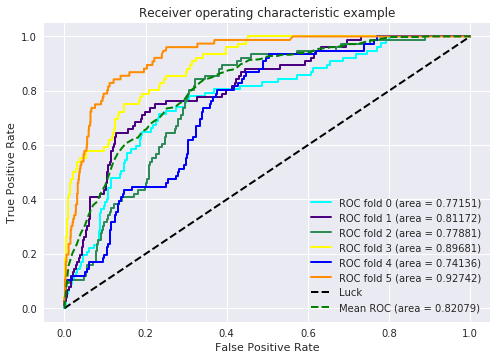

In [293]:
plot_roc(classifier_GB)

### AB

/home/user/env_py3/lib/python3.5/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


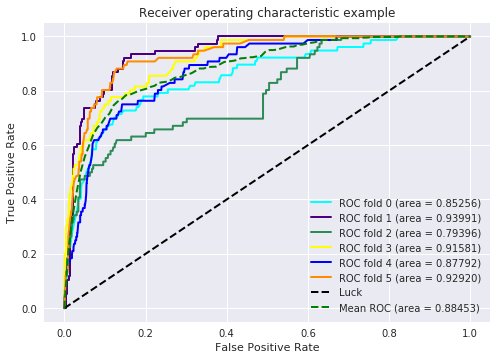

In [294]:
plot_roc(classifier_AB)

### RF

/home/user/env_py3/lib/python3.5/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


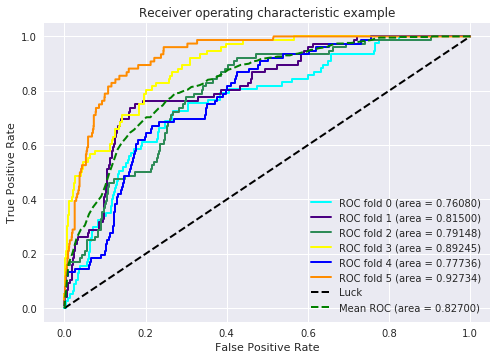

In [295]:
plot_roc(classifier_RF)

### ET

/home/user/env_py3/lib/python3.5/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


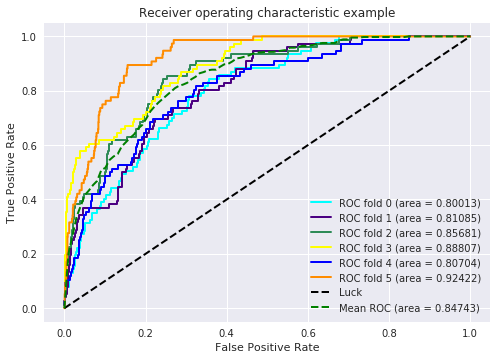

In [296]:
plot_roc(classifier_ET)

### BG

In [ ]:
plot_roc(classifier_BG)

### LR

In [ ]:
plot_roc(classifier_LR)

### SVC Linear

In [ ]:
plot_roc(classifier_SVCL)

### SVC RBF

In [ ]:
plot_roc(classifier_SVCR)

### KNN

In [ ]:
# Find best 'n_neighbors':
import operator
from sklearn.cross_validation import train_test_split
n_neighbors_best_list = []
X_train, X_test, y_train, y_test = train_test_split(X, y)
for n_neighbors in [1, 3, 5, 7, 9, 11, 13, 15, 17, 19, 21, 23, 25, 27, 29, 31]:
    knn = KNeighborsClassifier(n_neighbors)
    knn.fit(X_train, y_train)
    print(n_neighbors, knn.score(X_test, y_test))
    n_neighbors_best_list.append(knn.score(X_test, y_test))

n_neighbors_best, n_neighbors_value = max(enumerate(n_neighbors_best_list), key=operator.itemgetter(1))
print('\nBest n_neighbors is: %d \nwith value : %f' % (n_neighbors_best, n_neighbors_value))

plot_roc(KNeighborsClassifier(n_neighbors=n_neighbors_best))

### Benchmark of Kaggle public leaderboard progress for top 2 teams
Using Kaggle's 30% of actual reserved test data, top 1 & 2 team started from AUC=0.7+, progressing to 0.88+. Leaderboard feedback is expected to have contributed to a few 'jumps'.

<img align="left" src='./ref/LB-progress.png' width=100%>

<img align="left" src='./ref/LB-hist.png' width=100%>

### Reflection

The best model here, AdaBoostClassifier, used 6-fold cross validation to reach average AUC 0.88, based on test data split from training data. If using 'Kaggle's 30% of actual reserved test data', AUC is expected to drop, nevertheless, I think the initial performance can be reasonably good due to the AUC margin: 0.88 - 0.7 = 0.18.

# [5] What's next?

* Review confusion matrix. (High AUC doesn't translate to high accuracy of WNV identification. It's observed that improved AUC can deteriorate 'Averaged class error/accuracy' for WNV. Unbalanced classes, trade-off considerations.)
* Explore better strategy to use spray data
* Ensemble AdaBoost & ExtraTree (complement each other especially on CV Fold 2)
* Consider to use Leaderboard feedback. (It seems that this WNV result submission is no longer available in Kaggle.)
* Quantify the benefit to use this model by comparing against current reactive practice.


---